In [3]:
!pip install imageio
!pip install torch
!pip install kaggle
!pip install pywidgets

  Could not find a version that satisfies the requirement pywidgets (from versions: )
No matching distribution found for pywidgets


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import imageio
from torch.utils import data

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditya9729","key":"68340411e527ef421a2bd1cafdfaf7de"}'}

In [7]:
ls -lha kaggle.json


-rw-r--r-- 1 root root 66 Sep 22 14:00 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 54.7MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 61.7MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 108MB/s]
100% 163M/163M [00:01<00:00, 128MB/s]
100% 163M/163M [00:01<00:00, 114MB/s]
 87% 33.0M/37.9M [00:00<00:00, 122MB/s]
100% 37.9M/37.9M [00:00<00:00, 176MB/s]


In [10]:
!ls


depths.csv   sample_data	    test.zip   train.zip
kaggle.json  sample_submission.csv  train.csv


In [11]:
!unzip train.zip


Archive:  train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png   
  inflating: images/bb697642ae.png   
  inflating: images/d4acb30303.png   
  inflating: images/057eae4f34.png   
  inflating: images/9f0c9f3

In [0]:
class TGS(data.Dataset):
  def __init__(self,root_path,file_list):
    self.root_path=root_path
    self.file_list=file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self,index):
    file_id=self.file_list[index]
    image_folder=os.path.join(self.root_path,'images')
    image_path=os.path.join(image_folder,file_id+'.png')
    mask_folder=os.path.join(self.root_path,'masks')
    mask_path=os.path.join(mask_folder,file_id+'.png')    
    
    image=np.array(imageio.imread(image_path),dtype=np.uint8)
    
    mask=np.array(imageio.imread(mask_path),dtype=np.uint8)
    return image,mask    

In [30]:
train_mask=pd.read_csv('train.csv')
depth=pd.read_csv('depths.csv')
train_path='./'

file_list=list(train_mask['id'].values)
dataset=TGS(train_path,file_list)
dataset

In [15]:
train_mask.head(10)

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
5,782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
6,9842f69f8d,NaN
7,aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...
8,50d3073821,1 2121 9293 909
9,28f865caaa,NaN


In [0]:
def plot2array(image,mask):
  f,ax=plt.subplots(1,2)
  ax[0].imshow(image)
  ax[1].imshow(mask)
  ax[0].grid()
  ax[1].grid()
  ax[0].set_title('Image')
  ax[1].set_title('Mask')

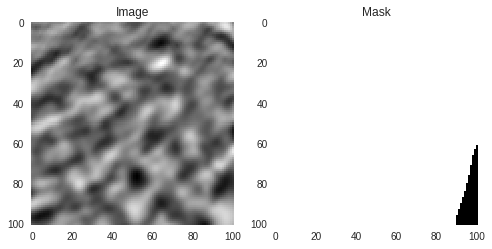

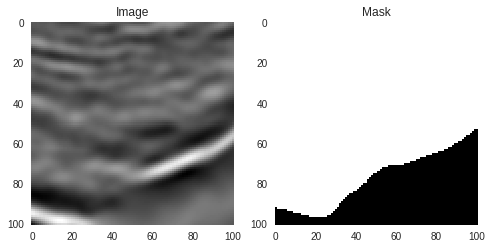

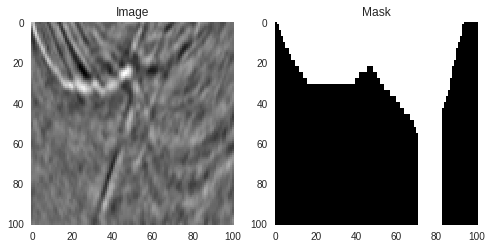

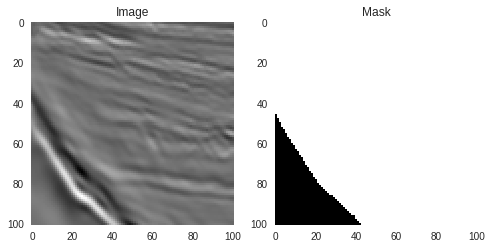

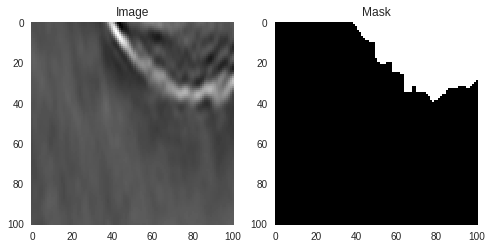

In [28]:
for i in range(5):
  image,mask=dataset[np.random.randint(0,len(dataset))]
  plot2array(image,mask)

Text(0.5,1,'Depths dist')

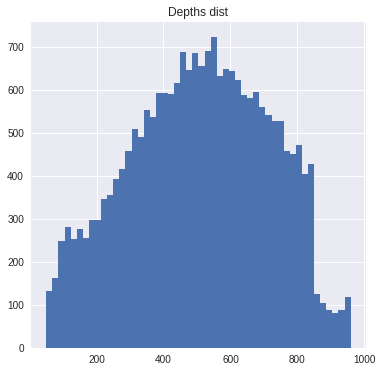

In [32]:
plt.figure(figsize=(6,6))
plt.hist(depth['z'],bins=50)
plt.title('Depths dist')

In [0]:
def rleToMask(rleString,height,width):
  rows,cols=height,width
  try:
    rleNumbers=[int(numString) for numString in rleString.split(' ')]
    rlePairs=np.array(rleNumbers).reshape(-1,2)
    img=np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
      index-=1
      img[index:index+length]=255
      
    img=img.reshape(cols,rows)
    img=img.T
  except:
    img=np.zeros((cols,rows))
  return img  


In [0]:
def salt_prop(imgArray):
  try:
    unique,counts=np.unique(imgArray,return_counts=True)
    return counts[1]/10201.
  except:
    return 0.0
  

In [0]:
train_mask['mask']=train_mask['rle_mask'].apply(lambda x:rleToMask(x,101,101))
train_mask['salt_proportion']=train_mask['mask'].apply(lambda x:salt_prop(x))


In [36]:
merged=train_mask.merge(depth,how='left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt vs depth')

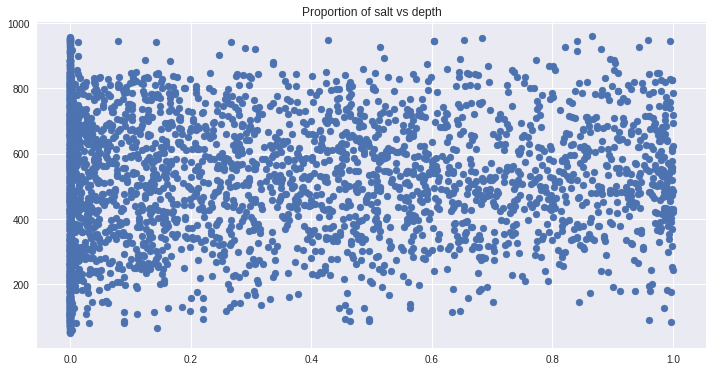

In [40]:
plt.figure(figsize=(12,6))
plt.scatter(merged['salt_proportion'],merged['z'])
plt.title('Proportion of salt vs depth')

In [0]:
#UNET IS AN AUTOENCODER,PREDICTS PIXEL WISE SEGMENTATION IN AN IAMGE ITSELF
def make_conv(in_ch,out_ch,kernel_size=3,stride=1,padding=1):
  return[nn.Conv2D(in_ch,out_ch,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),nn.BatchNorm2d(out_ch),nn.ReLU(inPlace=True)]
self.down1=nn.Sequential(*make_conv(128,64,3,1,1),*make_conv(64,64,3,1,1))
down1=self.down1(x)
out1=F.max_pool2d(down1,kernel_size=2,stride=2)



#UNET IS AN AUTOENCODER,PREDICTS PIXEL WISE SEGMENTATION IN AN IAMGE ITSELF
def make_conv(in_ch,out_ch,kernel_size=3,stride=1,padding=1):
  return[nn.Conv2D(in_ch,out_ch,kernel_size=kernel_size,stride=stride,padding=padding,bias=False),nn.BatchNorm2d(out_ch),nn.ReLU(inPlace=True)]
self.up4=nn.Sequential(*make_conv(128,64,3,1,1),*make_conv(64,64,3,1,1))
down1=self.down1(x)
out1=F.max_pool2d(down1,kernel_size=2,stride=2)

In [0]:
from keras.models import Model,load_model
from keras.layers import Input
from keras.layers.core import Lambda,RepeatVector,Reshape
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K

In [0]:
im_width=128
im_height=128
border=5
im_chan=5
n_features=1
path_train='../input/train/'
path_test='../input/test/'



In [46]:
input_img=Input((im_height,im_width,im_chan),name='img')
input_features=Input((n_features, ),name='feat')

c1=Conv2D(8,(3,3),activation='relu',padding='same')(input_img)
c1=Conv2D(8,(3,3),activation='relu',padding='same')(c1)
p1=MaxPooling2D((2,2))(c1)


c2=Conv2D(16,(3,3),activation='relu',padding='same')(p1)
c2=Conv2D(16,(3,3),activation='relu',padding='same')(c2)
p2=MaxPooling2D((2,2))(c2)


c3=Conv2D(32,(3,3),activation='relu',padding='same')(p2)
c3=Conv2D(32,(3,3),activation='relu',padding='same')(c3)
p3=MaxPooling2D((2,2))(c3)


c4=Conv2D(64,(3,3),activation='relu',padding='same')(p3)
c4=Conv2D(16,(3,3),activation='relu',padding='same')(c4)
p4=MaxPooling2D((2,2))(c4)


f_repeat=RepeatVector(8*8)(input_features)
f_conv=Reshape((8,8,n_features))(f_repeat)
p4_feat=concatenate([p4,f_conv],-1)


c5=Conv2D(128,(3,3),activation='relu',padding='same')(p4_feat)
c5=Conv2D(128,(3,3),activation='relu',padding='same')(c5)



u6=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c5)
u6=concatenate([u6,c4])
c6=Conv2D(64,(3,3),activation='relu',padding='same')(u6)
c6=Conv2D(64,(3,3),activation='relu',padding='same')(c6)


u7=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c6)
u7=concatenate([u7,c3])
c7=Conv2D(32,(3,3),activation='relu',padding='same')(u7)
c7=Conv2D(32,(3,3),activation='relu',padding='same')(c7)

u8=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c7)
u8=concatenate([u8,c2])
c8=Conv2D(16,(3,3),activation='relu',padding='same')(u8)
c8=Conv2D(16,(3,3),activation='relu',padding='same')(c8)

u9=Conv2DTranspose(8,(2,2),strides=(2,2),padding='same')(c8)
u9=concatenate([u9,c1])
c9=Conv2D(8,(3,3),activation='relu',padding='same')(u9)
c9=Conv2D(8,(3,3),activation='relu',padding='same')(c9)

outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)

model=Model(inputs=[input_img,input_features],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy')
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 5)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 8)  368         img[0][0]                        
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 128, 128, 8)  584         conv2d_13[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 

In [53]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator,array_to_img,load_img,img_to_array
from skimage.transform import resize

train_ids=next(os.walk(train_path+"images"))[2]

X=np.zeros((len(train_ids),im_height,im_width,im_chan),dtype=np.float32)
y=np.zeros((len(train_ids),im_height,im_width,1),dtype=np.float32)
X_feat=np.zeros((len(train_ids),n_features),dtype=np.float32)
print('Getting')
sys.stdout.flush()

for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
  path=train_path
  img=load_img(path+'/images/'+id_,grayscale=True)
  x_img=img_to_array(img)
  x_img=resize(x_img,(128,128,1),mode='constant',preserve_range=True)
  
  x_center_mean=x_img[border:-border,border:-border].mean()
  x_csum=(np.float32(x_img)-x_center_mean).cumsum(axis=0)
  x_csum-=x_csum[border:-border,border:-border].mean()
  x_csum/=max(1e-3,x_csum[border:-border,border:-border].std())
  
  mask=img_to_array(load_img(path+'/masks/'+id_,grayscale=True))
  mask=resize(mask,(128,128,1),mode='constant',preserve_range=True)
  
  X[n, ...,0]=x_img.squeeze()/255
  X[n, ...,1]=x_csum.squeeze()
  y[n]=mask/255
  
print('Done')

Getting


100%|██████████| 4000/4000 [00:25<00:00, 156.55it/s]

Done


In [58]:

from sklearn.model_selection import train_test_split

X_train,X_valid,X_feat_train,X_feat_valid,y_train,y_valid=train_test_split(train_mask,depth)

ValueError: ignored